In [1]:
# Estudo: Deeplearning para Dados Tabulares - BASE COVID_BRAZIL
# Autor: Willian Oliveira
# Start: 25/02/2023
# Motivação: Avaliar desempenho de quatro abordagens para resolução de problematicas de séries temporais. 
# Status do Estudo: Em Andamento

In [2]:
# Importanto bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# Configurando tamanho dos gráficos
rcParams['figure.figsize'] = 15, 8

# Importando bibliotecas para fixar SEED e reprodutibilidade do código
import tensorflow as tf
import os
import random

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED) # Fixando seed para resultados reprodutíveis.

# Reduzindo warning para melhor legibilidade dos outputs
import  warnings 
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Desativando GPU para comparativo com os codigos anteriores
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Definindo Utilitarios

In [3]:
def avaliaModelo(validation_data, validation_predictions, test_data, test_predictions):
    """Exibe os resultados das métricas de avaliação do treinamento e armazena seus valores em um dicionário."""

    from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

    validation_mse = mean_squared_error(validation_data, validation_predictions)
    validation_mape = mean_absolute_percentage_error(validation_data, validation_predictions)
    test_mse = mean_squared_error(test_data, test_predictions)
    test_mape = mean_absolute_percentage_error(test_data, test_predictions)

    print("Validation MSE: ", validation_mse)
    print("Validation MAPE: ", validation_mape)
    print("Test MSE: ", test_mse)
    print("Test MAPE: ", test_mape)

    return {'Validation MSE': validation_mse,
            'Validation MAPE': validation_mape,
            'Test MSE': test_mse,
            'Test MAPE': test_mape}

def missingValues(df):
    """Exibe percentual de valores faltantes por coluna do dataset."""

    from IPython.display import display, Markdown

    missing_values = df.isnull().sum() / len(df)*100
    missing_values = missing_values.sort_values(ascending=False)
    missing_values.rename("% missing values", inplace=True)
    display(Markdown(missing_values.to_markdown()))
    del missing_values


## AED e Pré-Processamento Básico

* Divida a série nos conjuntos de treinamento, validação e teste com as seguintes porcentagens: 50%, 25% e 25%, seguindo a ordem temporal.
* Compreenda a natureza da base de dados e seu comportamento visual.
* Desenvolva, avalie e compare os modelos no cenário da previsão de um passo à frente.

In [4]:
# Importando a base e explorando a série para melhor entendimento da natureza do estudo
BASE_NAME = 'covid_Brazil'
PATH = f'Data\{BASE_NAME}.csv'
df = pd.read_csv(PATH, sep=';')
df = df.set_index('date')
df.head()


,target
date,
2020-02-26,1
2020-02-27,0
2020-02-28,0
2020-02-29,1
2020-03-01,0


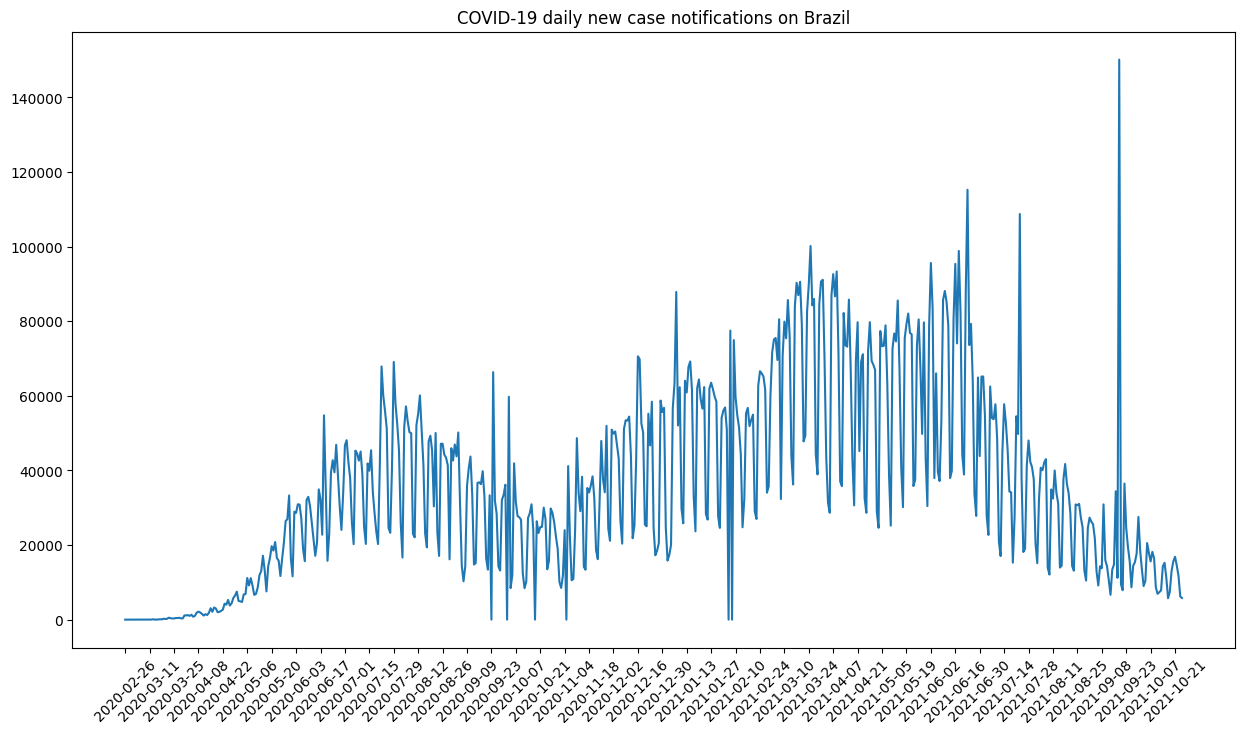

In [5]:
# Organizando e plotando a série para análise visual.
plt.plot(df)
plt.title('COVID-19 daily new case notifications on Brazil')
plt.xticks(np.arange(0, len(df), 14), rotation=45)
plt.show()

In [6]:
# Avaliando estatísticas básicas da série
df.describe()

,target
count,607.000000
mean,35809.115321
std,25586.168348
min,0.000000
25%,15333.000000
50%,32058.000000
75%,52666.500000
max,150106.000000


In [7]:
# Verificando % de valores faltantes
missingValues(df)

|        |   % missing values |
|:-------|-------------------:|
| target |                  0 |

In [8]:
# Dividindo a série em Treinamento, Validação e Teste, conforme as proporções solicitadas
train_data = df[:int(0.5 * len(df))]
validation_data = df[int(0.5 * len(df)):int(0.75 * len(df))]
test_data = df[int(0.75 * len(df)):]

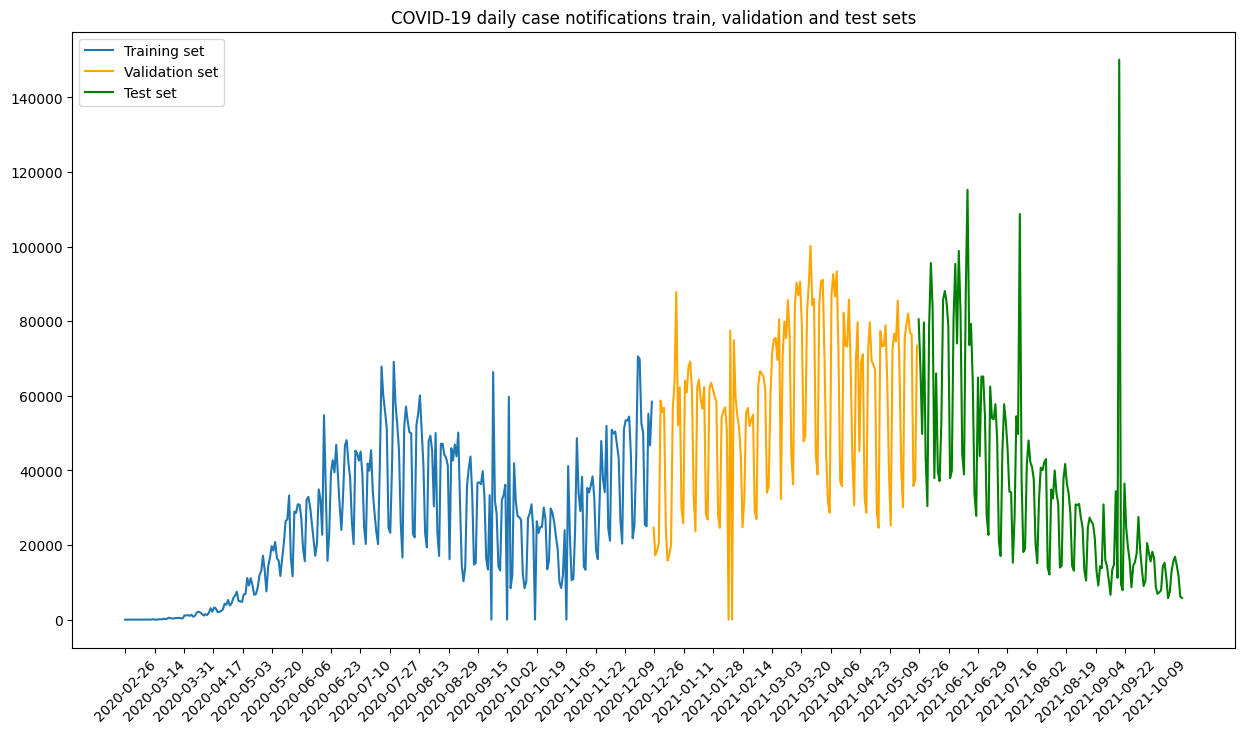

In [9]:
# Visualizando as séries de treinamento, validação e teste
plt.title('COVID-19 daily case notifications train, validation and test sets')
plt.plot(train_data, label='Training set')
plt.plot(validation_data, label='Validation set', color='orange')
plt.plot(test_data, label='Test set', color='green')
plt.legend()
plt.xticks(np.arange(0, len(df), len(df)/36), rotation=45)
plt.show()

In [10]:
%%time

validation_naive_forecast_prediction = validation_data[:-1]
test_naive_forecast_prediction = test_data[:-1]
naive_model_results = avaliaModelo(validation_data=validation_data[1:], 
                             validation_predictions=validation_naive_forecast_prediction, 
                             test_data=test_data[1:], 
                             test_predictions=test_naive_forecast_prediction)

Validation MSE:  565751620.7152318
Validation MAPE:  3.827970207775636e+18
Test MSE:  575737633.9668875
Test MAPE:  0.481070697098308
CPU times: total: 188 ms
Wall time: 308 ms


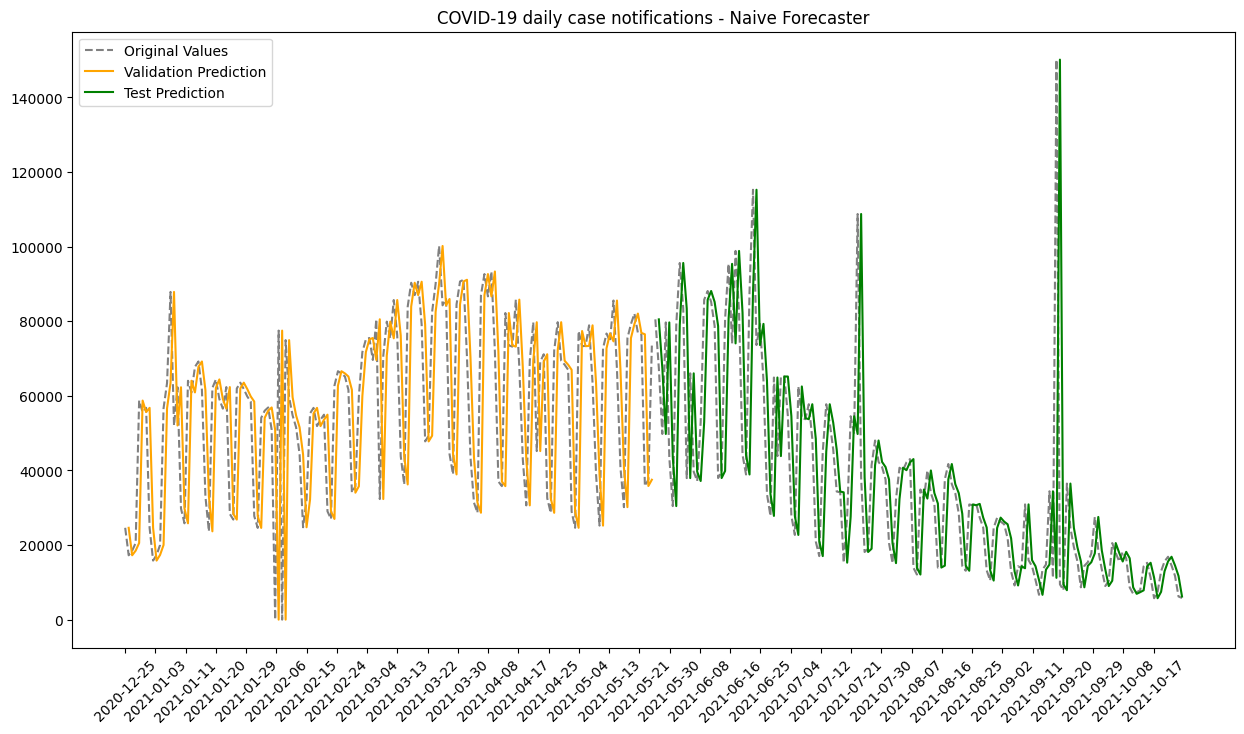

In [11]:
# Visualizando as previsões para os datasets de validação e teste.

plt.title('COVID-19 daily case notifications - Naive Forecaster')
plt.plot(validation_data.index, validation_data, label='Original Values', color='gray', linestyle='dashed')
plt.plot(test_data.index, test_data, color='gray', linestyle='dashed')
plt.plot(validation_data.index[1:], validation_naive_forecast_prediction, label='Validation Prediction', color='orange')
plt.plot(test_data.index[1:], test_naive_forecast_prediction, label='Test Prediction', color='green')
plt.legend()
plt.xticks(np.arange(0, len(df)/2, len(df)/70), rotation=45)
plt.xlim
plt.show()

## Treinamento de modelos de Aprendizado de Máquina LSTM
* Faça todo pré-processamento necessário para treinar um modelo de Aprendizado Profundo Long Short Term Memory.
* Utilize um grid search/random search para estabelecer os parâmetros do modelo.
* Utilize o conjunto de validação para selecionar o melhor modelo.
* Gere os erros de previsão e gráficos para o conjunto de treinamento, validação e teste. 

Sugestão: erro quadrático médio (EQM, ou MSE em inglês) e mean absolute percentage error (MAPE).

In [12]:
# Realizando janelamento no dataset completo, pois temos poucas observações.
def get_lags(series, lags):
    result = []
    if lags > 0:
        for lag in range(1, lags+1):
            result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
        return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
    else:
        for lag in range(-1, lags-1,-1):
            result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
        return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()


WINDOW_SIZE = 7 ## Janela de Alta Transmissão COVID-19  

sliding_windows_df = get_lags(df, WINDOW_SIZE)
X = sliding_windows_df
y = df.reindex(X.index)

In [13]:
# Visualizando o resultado do janelamento
for i in range(5):
    print(f'Window: {X.values.tolist()[i]} -> Label: {y.values.tolist()[i]}')

Window: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0] -> Label: [2]
Window: [2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0] -> Label: [0]
Window: [0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0] -> Label: [9]
Window: [9.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0] -> Label: [0]
Window: [0.0, 9.0, 0.0, 2.0, 0.0, 0.0, 0.0] -> Label: [7]


In [14]:
# Dividindo o dataset em partes de treino, validação e teste conforme percentuais solicitados na atividade
def make_train_test_splits(windows, labels, validadation_split=0.25, test_split=0.25):

  train_windows = windows[:int((1-(validadation_split + test_split)) * len(df))]
  train_labels = labels[:int((1-(validadation_split + test_split)) * len(df))]
  validation_windows = windows[int((1-(validadation_split + test_split)) * len(df)):int((1-test_split) * len(df))]
  validation_labels = labels[int((1-(validadation_split + test_split)) * len(df)):int((1-test_split) * len(df))]
  test_windows = windows[int((1-test_split) * len(df)):]
  test_labels = labels[int((1-test_split) * len(df)):]
  
  return train_windows, test_windows, validation_windows, validation_labels, train_labels, test_labels
  
train_windows, test_windows, validation_windows, validation_labels, train_labels, test_labels = make_train_test_splits(X, y)
len(train_windows), len(validation_windows), len(test_windows), len(train_labels), len(validation_labels), len(test_labels)

(303, 152, 145, 303, 152, 145)

In [15]:
# Visualizando os datasets
print('Training Set Sample:')
for i in range(5):
    print(f'Window: {train_windows.values.tolist()[i]} -> Label: {train_labels.values.tolist()[i]}')
print('\nValidation Set Sample:')
for i in range(5):
    print(f'Window: {validation_windows.values.tolist()[i]} -> Label: {validation_labels.values.tolist()[i]}')
print('\nTest Set Sample:')
for i in range(5):
    print(f'Window: {test_windows.values.tolist()[i]} -> Label: {test_labels.values.tolist()[i]}')

Training Set Sample:
Window: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0] -> Label: [2]
Window: [2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0] -> Label: [0]
Window: [0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0] -> Label: [9]
Window: [9.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0] -> Label: [0]
Window: [0.0, 9.0, 0.0, 2.0, 0.0, 0.0, 0.0] -> Label: [7]

Validation Set Sample:
Window: [56773.0, 55649.0, 58718.0, 20548.0, 18479.0, 17246.0, 24615.0] -> Label: [24605]
Window: [24605.0, 56773.0, 55649.0, 58718.0, 20548.0, 18479.0, 17246.0] -> Label: [15827]
Window: [15827.0, 24605.0, 56773.0, 55649.0, 58718.0, 20548.0, 18479.0] -> Label: [17341]
Window: [17341.0, 15827.0, 24605.0, 56773.0, 55649.0, 58718.0, 20548.0] -> Label: [20006]
Window: [20006.0, 17341.0, 15827.0, 24605.0, 56773.0, 55649.0, 58718.0] -> Label: [56648]

Test Set Sample:
Window: [78926.0, 30434.0, 43520.0, 79670.0, 49768.0, 67467.0, 80486.0] -> Label: [95601]
Window: [95601.0, 78926.0, 30434.0, 43520.0, 79670.0, 49768.0, 67467.0] -> Label: [83391]
Window: [83391.0,

In [16]:
%%time

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
from keras.initializers import HeNormal
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define arquitetura do modelo LSTM com Keras
def lstm_model(neurons=50, epochs=750):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', kernel_initializer=HeNormal(42), input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Cria um objeto KerasRegressor para usar com GridSearchCV
lstm = KerasRegressor(build_fn=lstm_model, neurons=50, batch_size=1, verbose=0)

# Define o pipeline para Normalização e GridSearchCV
pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('lstm', lstm)
])

# Define a lista de parâmetros para o GridSearchCV
param_grid = {
    'lstm__neurons': [50, 100],
    'lstm__epochs': [500, 750]
}

# Cria o objeto GridSearchCV
LSTM_model = GridSearchCV(pipeline, param_grid=param_grid, cv=3)

# Treina o modelo com GridSearchCV
LSTM_model.fit(train_windows, train_labels)

# Imprime os resultados
print(f"Melhores parâmetros: {LSTM_model.best_params_}")


Melhores parâmetros: {'lstm__epochs': 750, 'lstm__neurons': 50}
CPU times: total: 4min 39s
Wall time: 51min 45s


In [17]:
# Realizando previsões e avaliando métricas do modelo
LSTM_model_val_preds = LSTM_model.predict(validation_windows)
LSTM_model_test_preds = LSTM_model.predict(test_windows)

LSTM_model_results = avaliaModelo(validation_data=tf.squeeze(validation_labels), 
                                     validation_predictions=LSTM_model_val_preds,
                                     test_data=tf.squeeze(test_labels),
                                     test_predictions=LSTM_model_test_preds)

Validation MSE:  725739126.2458843
Validation MAPE:  2.453966785208289e+18
Test MSE:  475392693.21698827
Test MAPE:  0.4532799310017723


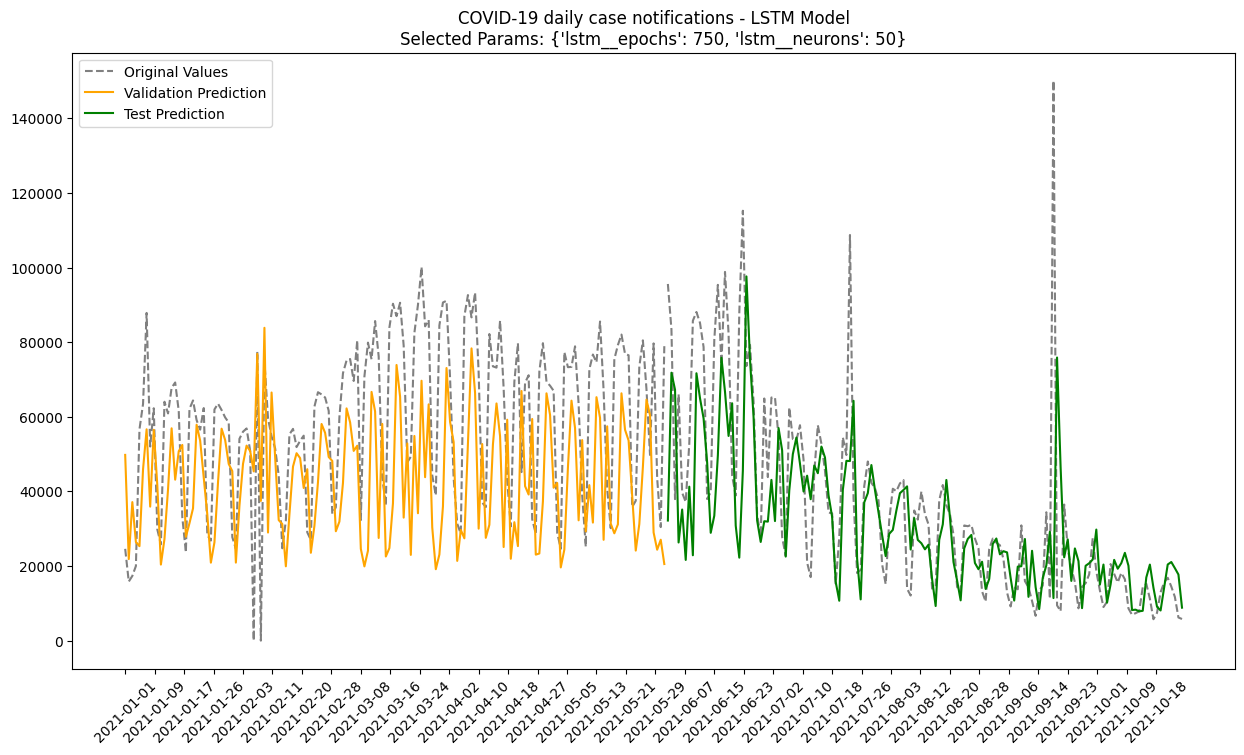

In [18]:
# Visualizando as previsões para os datasets de validação e teste.
plt.title(f'COVID-19 daily case notifications - LSTM Model\nSelected Params: {LSTM_model.best_params_}')
plt.plot(validation_windows.index, validation_labels, label='Original Values', color='gray', linestyle='dashed')
plt.plot(test_windows.index, test_labels, color='gray', linestyle='dashed')
plt.plot(validation_windows.index, LSTM_model_val_preds, label='Validation Prediction', color='orange')
plt.plot(test_windows.index, LSTM_model_test_preds, label='Test Prediction', color='green')
plt.legend()
plt.xticks(np.arange(0, len(validation_windows)+len(test_windows), (len(validation_windows) + len(test_windows))/36), rotation=45)
plt.xlim
plt.show()

In [19]:
LSTM_results =  pd.DataFrame(LSTM_model_results, index=['LSTM'])
Naive_results = pd.DataFrame(naive_model_results, index=['Naive'])

results = pd.concat([Naive_results, LSTM_results])
results.to_csv(f'Data\Results\{BASE_NAME}_results.csv', sep=';')